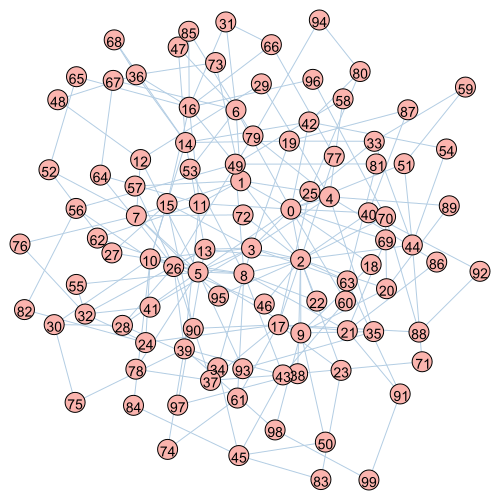

In [1]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a tree network using igraph method
#G = Graph.Erdos_Renyi(n = 100, p = 0.1, directed = False)
G = Graph.Barabasi(n = 100, m = 2, directed = False)
#G = Graph.Tree(100,2)



G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})


# Plotting with custom colors and saving to a file
p_style = {"bbox": (500, 500), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
output_path = "C:/Users/abbau/Downloads/ER400.pdf"
# Specify the path and filename here
plot(G, target=output_path, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [2]:
# Parameters
# Transmission rate
beta = 0.5
# Recovery rate
gamma = 0.5
#Time 
T = 3
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([1]), 'prob'] = 1

In [3]:
def calculate_gamma_power(node, graph, a=0.1, b=0.01):
    # Example: calculate gamma based on the degree of the node
    degree = graph[(graph['source'] == node) | (graph['target'] == node)].shape[0]
    return a * (degree ** b) 

In [4]:

def SIR_POENSEMBLE(g, p0, beta, T):
    # Get initial infection probabilities for each node
    start, nodes, init_probs = time.time(), p0['node'].tolist(), p0['prob'].tolist()
    
    # Create a dictionary to store recovery rates for each node
    gamma_dict = {node: calculate_gamma_power(node, g) for node in nodes}
    
    # Initialize probabilities for each state
    mrg_s = np.zeros((T, len(nodes)))
    mrg_i = np.zeros((T, len(nodes)))
    mrg_r = np.zeros((T, len(nodes)))

    # Set initial state probabilities
    mrg_i[0, :] = np.array(init_probs)
    mrg_s[0, :] = 1.0 - np.array(init_probs)

    # Precompute neighbors
    neighbors = {i: set() for i in nodes}
    for edge in g.itertuples(index=False):
        source, target = edge.source, edge.target
        neighbors[source].add(target)
        neighbors[target].add(source)

    # Master Equation Simulation
    for t in range(1, T):
        for i, node in enumerate(nodes):
            # Calculate the product term for the S and I updates
            product_term = np.prod([1 - beta * mrg_i[t - 1, nodes.index(neighbor)] for neighbor in neighbors[node]])

            # Update Susceptible (S)
            mrg_s[t, i] = mrg_s[t - 1, i] * product_term

            # Update Infected (I)
            mrg_i[t, i] = mrg_i[t - 1, i] + (1 - product_term) * mrg_s[t - 1, i] - gamma_dict[node] * mrg_i[t - 1, i]

            # Update Recovered (R)
            mrg_r[t, i] = mrg_r[t - 1, i] + gamma_dict[node] * mrg_i[t - 1, i]

        # Normalize the probabilities to sum to 1
        for i in range(len(nodes)):
            total = mrg_s[t, i] + mrg_i[t, i] + mrg_r[t, i]
            mrg_s[t, i] /= total
            mrg_i[t, i] /= total
            mrg_r[t, i] /= total
                        
    print("POENSEMBLE Runtime:   " + str(round(time.time() - start, 2)) + " seconds")
    return mrg_s, mrg_i, mrg_r

In [7]:
#predicted_s, predicted_i, predicted_r= SIR_POENSEMBLE(g, p0, beta, T)